In [2]:
import torch
import torch.nn as nn
from torch.functional import F
import lightning as L
import pandas as pd
import os
from torch.optim import (
    Adam,
)  # optim contains many optimizers. This time we're using Adam
from torch.distributions.uniform import (
    Uniform,
)  # So we can initialize our tensors with a uniform distribution
from torch.utils.data import TensorDataset, DataLoader

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
## create the training data for the neural network.
inputs = torch.tensor(
    [
        [1.0, 0.0, 0.0, 0.0],  # one-hot-encoding for Troll 2...
        [0.0, 1.0, 0.0, 0.0],  # ...is
        [0.0, 0.0, 1.0, 0.0],  # ...great
        [0.0, 0.0, 0.0, 1.0],
    ]
)  # ...Gymkata

labels = torch.tensor(
    [
        [0.0, 1.0, 0.0, 0.0],  # "Troll 2" is followed by "is"
        [0.0, 0.0, 1.0, 0.0],  # "is" is followed by "great"
        [
            0.0,
            0.0,
            0.0,
            1.0,
        ],  # "great" isn't followed by anything, but we'll pretend it was followed by "Gymkata"
        [0.0, 1.0, 0.0, 0.0],
    ]
)  # "Gymkata", just like "Troll 2", is followed by "is".

In [5]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [16]:
class WordEmbeddingsFromScratch(L.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        L.seed_everything(42)
        # Param for uniform distribution
        min_value=-0.5
        max_value=0.5
        # We use uniform distribution to initialize weights because Linear
        # layers in torhc use that to initialize weights in our case unifrom distribution is U(-0.5,0.5)
        # in case of Linear layer its U(-sqrt(h),sqrt(k)) where k=1/input_features
        # We have 4 input features so its U(-0.5,0.5) if calculated
        # 1---|       |----o1      then all softmax
        # 2---|___sum|------ 02
        # 3---|         |---03
        # 4----|___sum|        04
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        ## Now we initialize the weights that come out of the hidden layer to the "output"
        ## NOTE: Again, we are excluding bias terms. This time, we exclude them simply because
        ##       we do not need them.
        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss=nn.CrossEntropyLoss()
    def forward(self, input):
        input=input[0]
        input_top_hidden = (
            (input[0] * self.input1_w1)
            + (input[0] * self.input2_w1)
            + (input[0] * self.input3_w1)
            + (input[0] * self.input4_w1)
        )
        input_bottom_hidden = (
            (input[0] * self.input1_w2)
            + (input[0] * self.input2_w2)
            + (input[0] * self.input3_w2)
            + (input[0] * self.input4_w2)
        )
        output1 = (input_top_hidden * self.output1_w1) + (
            input_bottom_hidden * self.output1_w2
        )
        output2 = (input_top_hidden * self.output2_w1) + (
            input_bottom_hidden * self.output2_w2
        )
        output3 = (input_top_hidden * self.output3_w1) + (
            input_bottom_hidden * self.output3_w2
        )
        output4 = (input_top_hidden * self.output4_w1) + (
            input_bottom_hidden * self.output4_w2
        )
        output_softmax=torch.stack([output1,output2,output3,output4])
        return (output_softmax)
    def configure_optimizers(self):
        return Adam(self.parameters(),lr=0.1)
    def training_step(self, batch,batch_idx):
        input_i,label_i=batch
        print(input_i,label_i)
        print("output")

        output_i=self.forward(input_i)
        print(output_i)
        loss = self.loss(output_i, label_i[0])
        return loss

In [17]:
modelFromScratch = WordEmbeddingsFromScratch()  # create the model...

print("Before optimization, the parameters are...")
for name, param in modelFromScratch.named_parameters():
    print(name, torch.round(param.data, decimals=2))

Seed set to 42


Before optimization, the parameters are...
input1_w1 tensor(0.3800)
input1_w2 tensor(0.4200)
input2_w1 tensor(-0.1200)
input2_w2 tensor(0.4600)
input3_w1 tensor(-0.1100)
input3_w2 tensor(0.1000)
input4_w1 tensor(-0.2400)
input4_w2 tensor(0.2900)
output1_w1 tensor(0.4400)
output1_w2 tensor(-0.3700)
output2_w1 tensor(0.4300)
output2_w2 tensor(0.0900)
output3_w1 tensor(0.3700)
output3_w2 tensor(0.0700)
output4_w1 tensor(0.2400)
output4_w2 tensor(-0.0700)


In [18]:
data = {
    "w1": [
        modelFromScratch.input1_w1.item(),  ## item() pulls out the tensor value as a float
        modelFromScratch.input2_w1.item(),
        modelFromScratch.input3_w1.item(),
        modelFromScratch.input4_w1.item(),
    ],
    "w2": [
        modelFromScratch.input1_w2.item(),
        modelFromScratch.input2_w2.item(),
        modelFromScratch.input3_w2.item(),
        modelFromScratch.input4_w2.item(),
    ],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.382269,0.415004,Troll2,input1
1,-0.117136,0.459306,is,input2
2,-0.109552,0.100895,great,input3
3,-0.243428,0.293641,Gymkata,input4


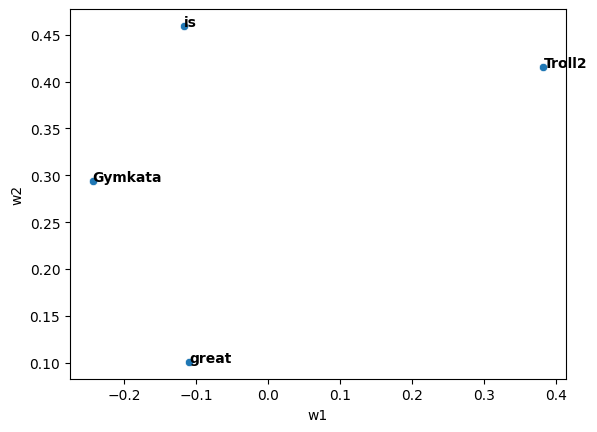

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df, x="w1", y="w2")

## add the token that each dot represents to the graph
# Troll 2
plt.text(
    df.w1[0],
    df.w2[0],
    df.token[0],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# is
plt.text(
    df.w1[1],
    df.w2[1],
    df.token[1],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# great
plt.text(
    df.w1[2],
    df.w2[2],
    df.token[2],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# Gymkata
plt.text(
    df.w1[3],
    df.w2[3],
    df.token[3],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

plt.show()

In [20]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/home/hadi/Documents/statquest/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training: |          | 0/? [00:00<?, ?it/s]

tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]])
output
tensor([-0.5042,  0.0806,  0.0535, -0.1108], grad_fn=<StackBackward0>)
tensor([[0., 1., 0., 0.]]) tensor([[0., 0., 1., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 1., 0.]]) tensor([[0., 0., 0., 1.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 0., 1.]]) tensor([[0., 1., 0., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]])
output
tensor([-0.7813,  0.9869,  0.1558, -0.2870], grad_fn=<StackBackward0>)
tensor([[0., 1., 0., 0.]]) tensor([[0., 0., 1., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 1., 0.]]) tensor([[0., 0., 0., 1.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 0., 1.]]) tensor([[0., 1., 0., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]])
output
ten

`Trainer.fit` stopped: `max_epochs=100` reached.


tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 0., 1.]]) tensor([[0., 1., 0., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]])
output
tensor([-7.3241,  5.6328, -5.3499, -5.8877], grad_fn=<StackBackward0>)
tensor([[0., 1., 0., 0.]]) tensor([[0., 0., 1., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 1., 0.]]) tensor([[0., 0., 0., 1.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 0., 1.]]) tensor([[0., 1., 0., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[1., 0., 0., 0.]]) tensor([[0., 1., 0., 0.]])
output
tensor([-7.3265,  5.6363, -5.3531, -5.8908], grad_fn=<StackBackward0>)
tensor([[0., 1., 0., 0.]]) tensor([[0., 0., 1., 0.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 0., 1., 0.]]) tensor([[0., 0., 0., 1.]])
output
tensor([0., 0., 0., 0.], grad_fn=<StackBackward0>)
tensor([[0., 

In [21]:
data = {
    "w1": [
        modelFromScratch.input1_w1.item(),  ## item() pulls out the tensor value as a float
        modelFromScratch.input2_w1.item(),
        modelFromScratch.input3_w1.item(),
        modelFromScratch.input4_w1.item(),
    ],
    "w2": [
        modelFromScratch.input1_w2.item(),
        modelFromScratch.input2_w2.item(),
        modelFromScratch.input3_w2.item(),
        modelFromScratch.input4_w2.item(),
    ],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.257723,1.467693,Troll2,input1
1,-0.241683,1.511995,is,input2
2,-0.234098,1.153584,great,input3
3,-0.367974,1.346331,Gymkata,input4


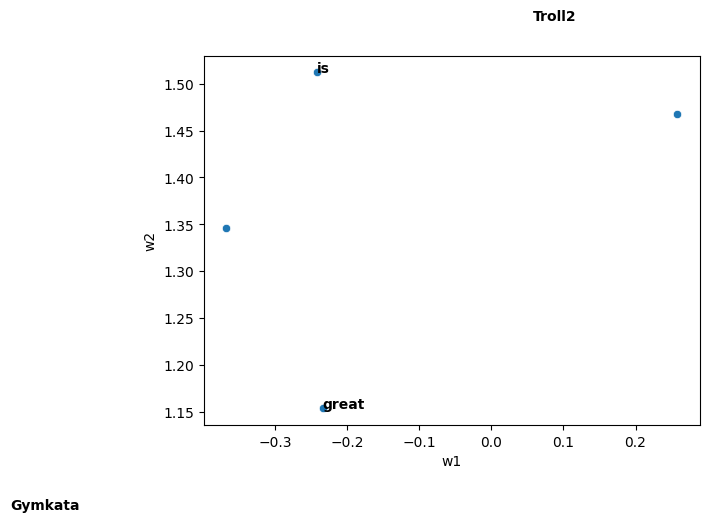

In [22]:
sns.scatterplot(data=df, x="w1", y="w2")

## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.

## Troll 2
plt.text(
    df.w1[0] - 0.2,
    df.w2[0] + 0.1,
    df.token[0],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

## is
plt.text(
    df.w1[1],
    df.w2[1],
    df.token[1],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

## great
plt.text(
    df.w1[2],
    df.w2[2],
    df.token[2],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

## gymkata
plt.text(
    df.w1[3] - 0.3,
    df.w2[3] - 0.3,
    df.token[3],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

plt.show()

In [23]:
## Let's see what the model predicts

## First, let's create a softmax object...
softmax = nn.Softmax(
    dim=0
)  ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

## Now let's...

## print the predictions for "Troll2"
print(
    torch.round(
        softmax(modelFromScratch(torch.tensor([[1.0, 0.0, 0.0, 0.0]]))), decimals=2
    )
)

## print the predictions for "is"
print(
    torch.round(
        softmax(modelFromScratch(torch.tensor([[0.0, 1.0, 0.0, 0.0]]))), decimals=2
    )
)

## print the predictions for "great"
print(
    torch.round(
        softmax(modelFromScratch(torch.tensor([[0.0, 0.0, 1.0, 0.0]]))), decimals=2
    )
)

## print the predictions for "Gymkata"
print(
    torch.round(
        softmax(modelFromScratch(torch.tensor([[0.0, 0.0, 0.0, 1.0]]))), decimals=2
    )
)

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)
tensor([0.2500, 0.2500, 0.2500, 0.2500], grad_fn=<RoundBackward1>)
tensor([0.2500, 0.2500, 0.2500, 0.2500], grad_fn=<RoundBackward1>)
tensor([0.2500, 0.2500, 0.2500, 0.2500], grad_fn=<RoundBackward1>)


In [24]:
class WordEmbeddingWithLinear(L.LightningModule):

    def __init__(self):

        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        L.seed_everything(seed=42)

        ## In order to initialize weights from the 4 inputs (one for each unique word)
        ##       to the 2 nodes in the hidden layer (top and bottom nodes), we simply make
        ##       one call to nn.Linear() where in_features specifies the number of
        ##       inputs and out_features specifies the number of nodes we
        ##       are connecting them to. Since we don't want to use bias terms,
        ##       we set bias=False
        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        ## Now, in order to connect the 2 nodes in the hidden layer to the 4 outputs, we
        ##       make one call to nn.Linear(), where in_features specifies the number of
        ##       nodes in hidden layer and out_features specifies the number of output values we want.
        ##       And again, we can set bias=False
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)

        ## We'll use CrossEntropyLoss in training_step()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):

        ## Unlike before, where we did all the math by hand, now we can
        ## simply pass the input values to the weights we created with nn.Linear()
        ## between the input and the hidden layer and save the result in "hidden"
        ##
        ## NOTE: Unlike before, we don't need to strip off the extra brackets from the
        ##       input. the Linear ojbect knows what to do.
        hidden = self.input_to_hidden(input)

        ## Then we pass "hidden" to the weights we created with nn.Linear()
        ## between the hidden layer and the output.
        output_values = self.hidden_to_output(hidden)

        return output_values

    def configure_optimizers(self):
        # this configures the optimizer we want to use for backpropagation.

        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        # take a step during gradient descent.

        input_i, label_i = batch  # collect input
        output_i = self.forward(input_i)  # run input through the neural network
        loss = self.loss(output_i, label_i)  ## loss = cross entropy

        return loss

In [25]:
modelLinear = WordEmbeddingWithLinear()

print("Before optimization, the parameters are...")
for name, param in modelLinear.named_parameters():
    print(name, torch.round(param.data, decimals=2))

Seed set to 42


Before optimization, the parameters are...
input_to_hidden.weight tensor([[ 0.3800,  0.4200, -0.1200,  0.4600],
        [-0.1100,  0.1000, -0.2400,  0.2900]])
hidden_to_output.weight tensor([[ 0.6200, -0.5200],
        [ 0.6100,  0.1300],
        [ 0.5200,  0.1000],
        [ 0.3400, -0.1000]])


In [26]:
data = {
    ## NOTE: Unlike before, when we called item() on each individual
    ##       Weight, now that we are using nn.Linear, we access the
    ##       Weights with ".weight". We then have to remove the gradients
    ##       associated with each Weight, so we also call .detach().
    ##       Lastly, we then convert the tensor to a numpy array with
    ##       numpy().
    "w1": modelLinear.input_to_hidden.weight.detach()[
        0
    ].numpy(),  # [0] = Weights to top activation function
    "w2": modelLinear.input_to_hidden.weight.detach()[
        1
    ].numpy(),  # [1] = Weights to bottom activation function
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.382269,-0.109552,Troll2,input1
1,0.415004,0.100895,is,input2
2,-0.117136,-0.243428,great,input3
3,0.459306,0.293641,Gymkata,input4


In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph

## Troll 2
plt.text(
    df.w1[0],
    df.w2[0],
    df.token[0],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)
## is
plt.text(
    df.w1[1],
    df.w2[1],
    df.token[1],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)
## great
plt.text(
    df.w1[2],
    df.w2[2],
    df.token[2],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

## Gymkata
plt.text(
    df.w1[3],
    df.w2[3],
    df.token[3],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

plt.show()

In [27]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelLinear, train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/hadi/Documents/statquest/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which m

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [28]:
data = {
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"],
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,2.510447,-0.068821,Troll2,input1
1,-1.017650,2.482441,is,input2
2,-1.974159,-1.818951,great,input3
3,2.435523,-0.222807,Gymkata,input4


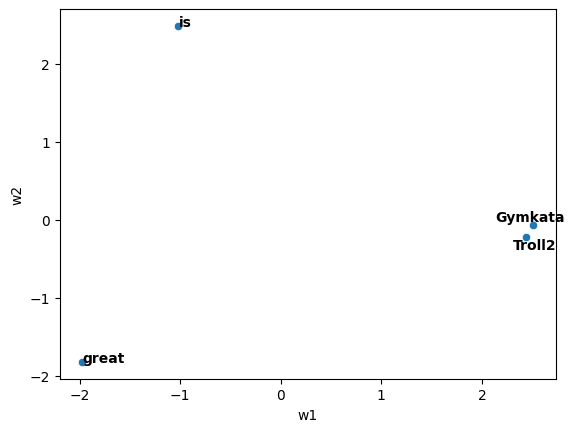

In [29]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph
## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.

# Troll 2
plt.text(
    df.w1[0] - 0.2,
    df.w2[0] - 0.3,
    df.token[0],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# is
plt.text(
    df.w1[1],
    df.w2[1],
    df.token[1],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# great
plt.text(
    df.w1[2],
    df.w2[2],
    df.token[2],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

# Gymkata
plt.text(
    df.w1[3] - 0.3,
    df.w2[3] + 0.2,
    df.token[3],
    horizontalalignment="left",
    size="medium",
    color="black",
    weight="semibold",
)

plt.show()

In [30]:
# Let's see what the model predicts
softmax = nn.Softmax(
    dim=1
)  ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

print(
    torch.round(softmax(modelLinear(torch.tensor([[1.0, 0.0, 0.0, 0.0]]))), decimals=2)
)  ## print the predictions for "Troll2"
print(
    torch.round(softmax(modelLinear(torch.tensor([[0.0, 1.0, 0.0, 0.0]]))), decimals=2)
)  ## print the predictions for "is"
print(
    torch.round(softmax(modelLinear(torch.tensor([[0.0, 0.0, 1.0, 0.0]]))), decimals=2)
)  ## print the predictions for "great"
print(
    torch.round(softmax(modelLinear(torch.tensor([[0.0, 0.0, 0.0, 1.0]]))), decimals=2)
)  ## print the predictions for "Gymkata"

tensor([[0., 1., 0., 0.]], grad_fn=<RoundBackward1>)
tensor([[0., 0., 1., 0.]], grad_fn=<RoundBackward1>)
tensor([[0., 0., 0., 1.]], grad_fn=<RoundBackward1>)
tensor([[0., 1., 0., 0.]], grad_fn=<RoundBackward1>)


Use nn.Embedding() to load and use pre-trained Word Embeddings
Now that we have created embeddings for each token in the vocabulary, we can store them in an nn.Embedding() object so that we can access them with the tokens, rather than the one-hot-encoded versions of the tokens. This makes them easily portable to other applications.

First, let's just print out the embedding values that we created in modelLinear and that we want to add to an nn.Embedding() object.

modelLinear.input_to_hidden.weight

##  NOTE: We have to transpose the original embedding values (from w1 and w2) for nn.Embedding()
##        and we do this with adding a '.T' to modelLinear.input_to_hidden.weight.T
word_embeddings = nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

In [31]:
##  NOTE: We have to transpose the original embedding values (from w1 and w2) for nn.Embedding()
##        and we do this with adding a '.T' to modelLinear.input_to_hidden.weight.T
word_embeddings = nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

In [32]:
word_embeddings.weight

Parameter containing:
tensor([[ 2.5104, -0.0688],
        [-1.0177,  2.4824],
        [-1.9742, -1.8190],
        [ 2.4355, -0.2228]])

In [33]:
word_embeddings(torch.tensor(0))

tensor([ 2.5104, -0.0688])

In [34]:
vocab = {"Troll2": 0, "is": 1, "great": 2, "Gymkata": 3}

In [35]:
word_embeddings(torch.tensor(vocab["Troll2"]))

tensor([ 2.5104, -0.0688])

In [36]:
word_embeddings(torch.tensor(vocab['Gymkata']))

tensor([ 2.4355, -0.2228])